# Chunks EDA - Scientific Papers Analysis

Exploratory Data Analysis of processed paper chunks from ArXiv dataset.

This notebook analyzes:
- Field/section distribution
- Source distribution
- Text statistics
- Word clouds by field

**Configure the `CHUNK_LIMIT` parameter below to control how many chunks to load.**


In [9]:
from pathlib import Path

import ijson
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud


sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Configuration

In [10]:
CHUNK_LIMIT = 100000  # Set to None to load all chunks
DATA_FILE = Path("../data/processed/chunks_arxiv.json")

## Load Chunks

In [11]:
chunks = []
with open(DATA_FILE, "rb") as f:
    parser = ijson.items(f, "item")
    for chunk in tqdm(parser, desc="Loading chunks", total=CHUNK_LIMIT, unit="chunk"):
        chunks.append(chunk)
        if CHUNK_LIMIT and len(chunks) >= CHUNK_LIMIT:
            break

print(f"Loaded {len(chunks):,} chunks")

df = pd.DataFrame(chunks)
df["text_length"] = df["text"].str.len()
df["word_count"] = df["text"].str.split().str.len()

Loading chunks: 100%|█████████▉| 99999/100000 [00:01<00:00, 98605.50chunk/s] 


Loaded 100,000 chunks


## Basic Statistics

In [12]:
print(f"Total chunks: {len(df):,}")
print(f"Unique papers: {df['paper_id'].nunique():,}")
print(f"\nText length: {df['text_length'].mean():.0f} ± {df['text_length'].std():.0f}")
print(f"Word count: {df['word_count'].mean():.0f} ± {df['word_count'].std():.0f}")

df.head()

Total chunks: 100,000
Unique papers: 7,144

Text length: 2567 ± 1292
Word count: 462 ± 250


,chunk_id,text,paper_id,source,section,position,metadata,score,embedding,text_length,word_count
0,5cd47be7-8358-5263-b750-5a19e2568c53,additive models play an important role in semi...,arxiv_0,arxiv,abstract,0,{},None,None,930,145
1,fd86ec44-61cb-5a4a-a0d9-fc61b08e5022,additive models <BRACKET> provide an important...,arxiv_0,arxiv,introduction,1,{},None,None,2981,495
2,e1e4e27a-50b0-5fee-8d14-358054065daf,we will not address the question how to check ...,arxiv_0,arxiv,introduction,2,{},None,None,2838,496
3,20954dd0-0c8c-5755-83ab-7d5108d6ee0f,because these notations will only be used in d...,arxiv_0,arxiv,methods,3,{},None,None,3001,509
4,a45daf1c-847b-554e-baaf-4920729555b6,in this paper we provide some learning rates f...,arxiv_0,arxiv,methods,4,{},None,None,2945,505


## Section Distribution

results        : 34,135 ( 34.1%)
methods        : 30,694 ( 30.7%)
introduction   : 17,422 ( 17.4%)
conclusion     : 10,510 ( 10.5%)
abstract       :  7,144 (  7.1%)
other          :     95 (  0.1%)


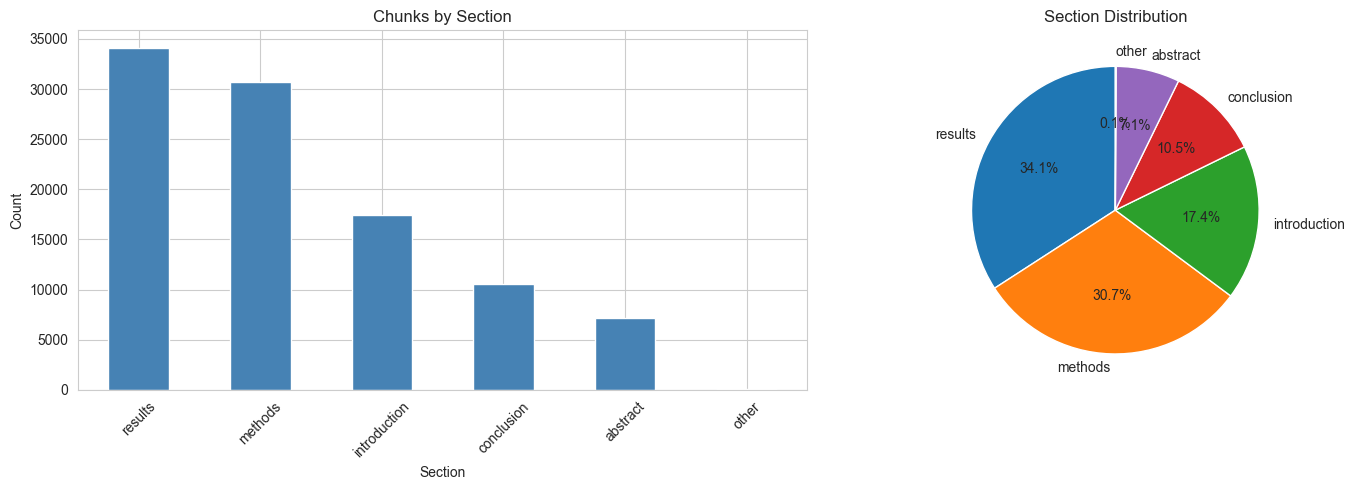

In [13]:
section_counts = df["section"].value_counts()

for section, count in section_counts.items():
    print(f"{section:15s}: {count:6,} ({count / len(df) * 100:5.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

section_counts.plot(kind="bar", ax=axes[0], color="steelblue")
axes[0].set_title("Chunks by Section")
axes[0].set_xlabel("Section")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=45)

axes[1].pie(section_counts.values, labels=section_counts.index, autopct="%1.1f%%", startangle=90)
axes[1].set_title("Section Distribution")

plt.tight_layout()
plt.show()

## Word Clouds by Section

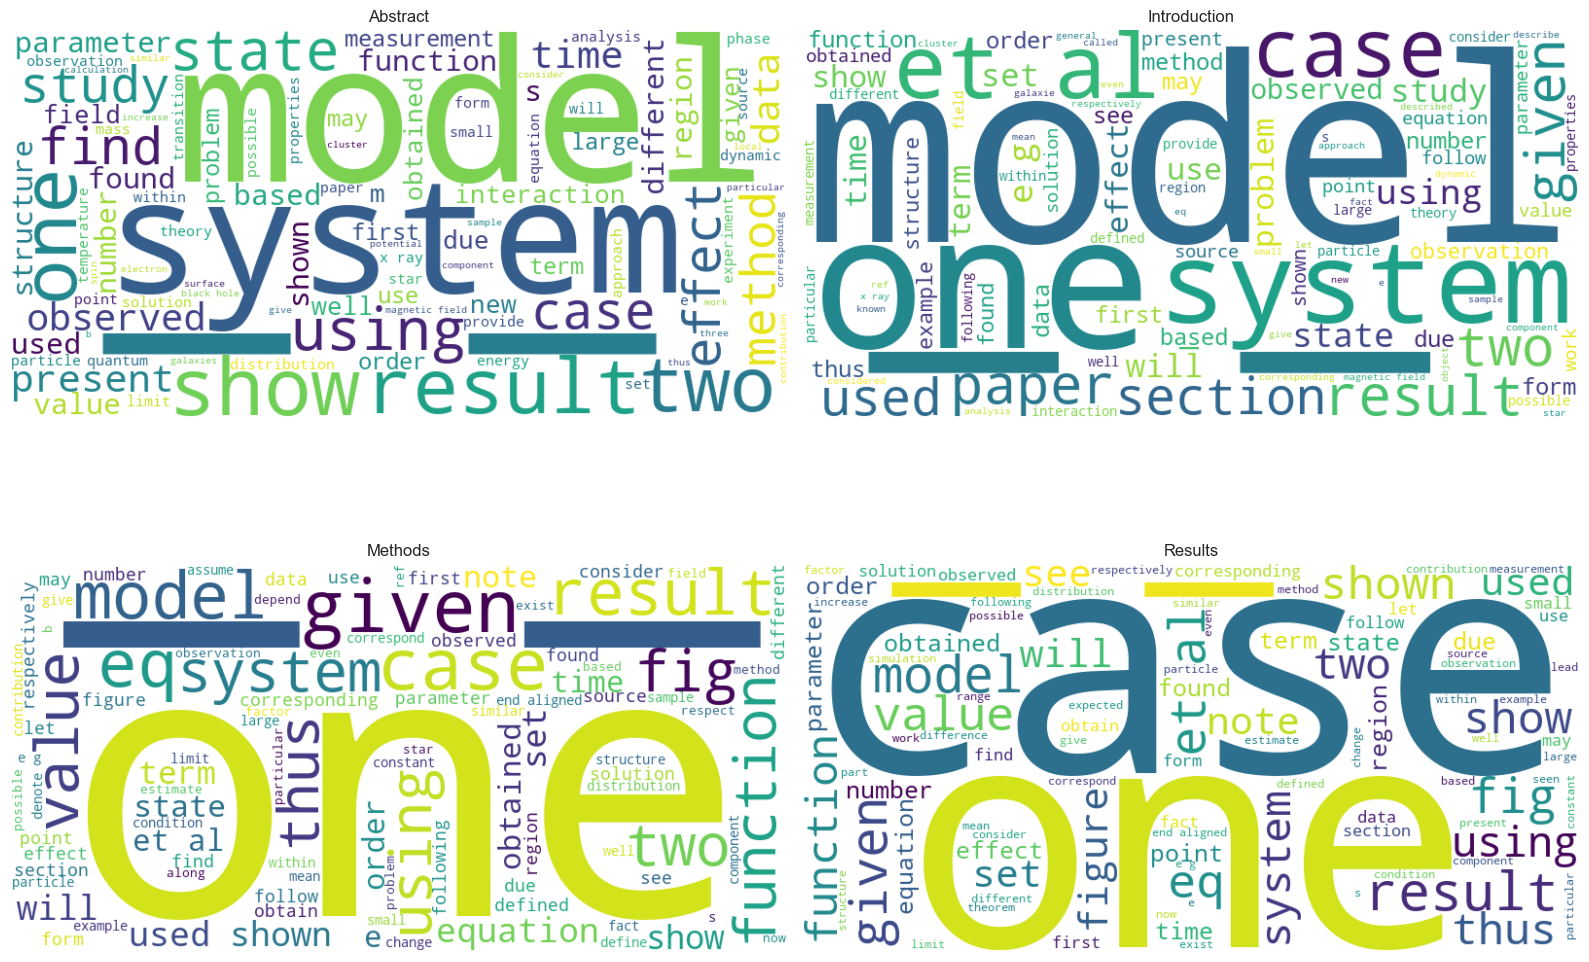

In [14]:
import re


def clean_text(text):
    text = re.sub(r"\b(MATH|BRACKET|math|bracket)\b", "", text, flags=re.IGNORECASE)
    text = re.sub(r"<[^>]+>", "", text)  # Remove XML/HTML tags
    text = re.sub(r"\s+", " ", text)  # Normalize whitespace
    return text.strip()


sections = df["section"].unique()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, section in enumerate(sections):
    if idx >= len(axes):
        break

    section_text = " ".join(df[df["section"] == section]["text"].values)
    cleaned_text = clean_text(section_text)

    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis", max_words=100).generate(
        cleaned_text
    )

    axes[idx].imshow(wordcloud, interpolation="bilinear")
    axes[idx].set_title(f"{section.capitalize()}")
    axes[idx].axis("off")

for idx in range(len(sections), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

## Topic Analysis

Quantum Physics     : 12,966 ( 13.0%)
Plasma Physics      :  6,534 (  6.5%)
Machine Learning    :    347 (  0.3%)
Astrophysics        : 17,189 ( 17.2%)
Biology             : 45,809 ( 45.8%)
Neuroscience        :    782 (  0.8%)


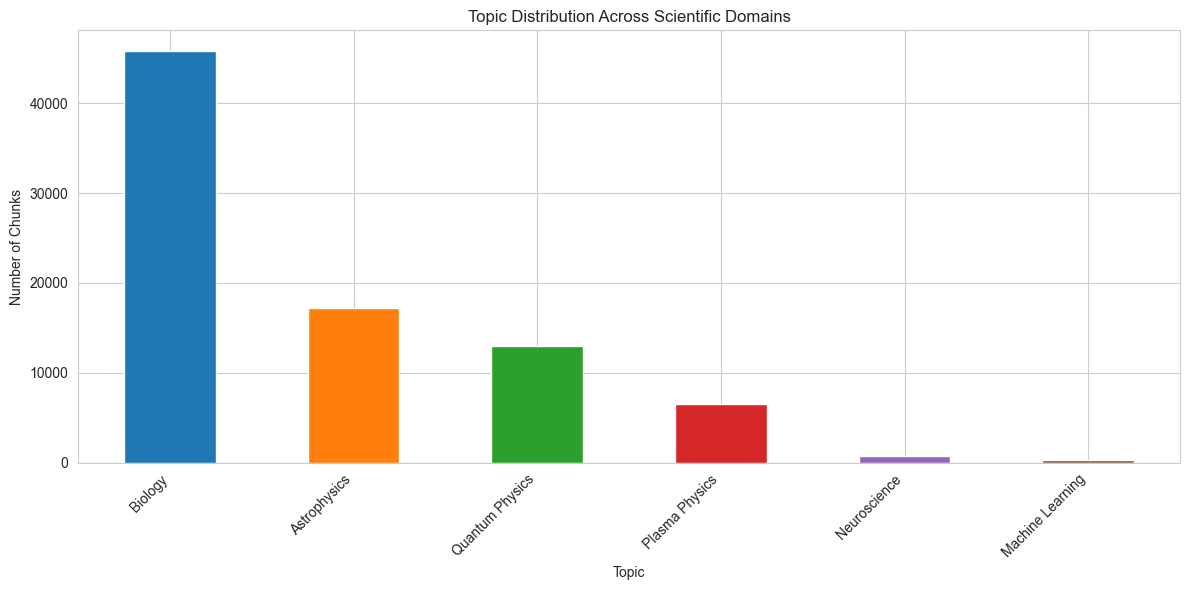

In [15]:
topics = {
    "Quantum Physics": ["quantum", "qubit", "entanglement", "superposition", "coherence", "decoherence"],
    "Plasma Physics": ["plasma", "tokamak", "fusion", "magnetohydrodynamic", "MHD", "confinement"],
    "Machine Learning": ["neural network", "deep learning", "machine learning", "CNN", "RNN", "transformer"],
    "Astrophysics": ["galaxy", "cosmic", "cosmology", "stellar", "black hole", "dark matter"],
    "Biology": ["protein", "gene", "DNA", "cell", "molecular", "organism"],
    "Neuroscience": ["neural", "brain", "neuron", "cognitive", "synapse", "cortex"],
}

topic_counts = {}
for topic, keywords in topics.items():
    pattern = "|".join(keywords)
    count = df["text"].str.lower().str.contains(pattern, regex=True).sum()
    topic_counts[topic] = count
    print(f"{topic:20s}: {count:6,} ({count / len(df) * 100:5.1f}%)")

topic_series = pd.Series(topic_counts).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
topic_series.plot(kind="bar", color=plt.cm.tab10(range(len(topic_series))))
plt.title("Topic Distribution Across Scientific Domains")
plt.ylabel("Number of Chunks")
plt.xlabel("Topic")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Statistics by Section

              text_length_mean  text_length_median  text_length_std  \
section                                                               
abstract                1582.0               974.0           3215.0   
conclusion              2036.0              2040.0           2517.0   
introduction            2809.0              2829.0            232.0   
methods                 2750.0              2765.0            299.0   
other                   1444.0              1365.0            928.0   
results                 2652.0              2738.0            553.0   

              word_count_mean  word_count_median  word_count_std  count  
section                                                                  
abstract                273.0              164.0           571.0   7144  
conclusion              400.0              448.0           552.0  10510  
introduction            490.0              496.0            30.0  17422  
methods                 489.0              496.0            3

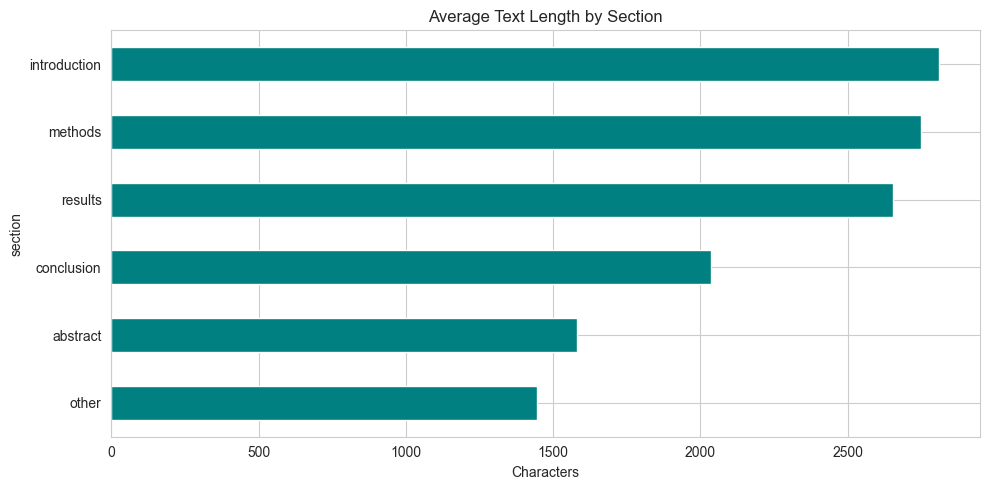

In [16]:
section_stats = (
    df.groupby("section")
    .agg({"text_length": ["mean", "median", "std"], "word_count": ["mean", "median", "std"], "chunk_id": "count"})
    .round(0)
)

section_stats.columns = ["_".join(col) for col in section_stats.columns]
section_stats = section_stats.rename(columns={"chunk_id_count": "count"})
print(section_stats)

plt.figure(figsize=(10, 5))
df.groupby("section")["text_length"].mean().sort_values().plot(kind="barh", color="teal")
plt.title("Average Text Length by Section")
plt.xlabel("Characters")
plt.tight_layout()
plt.show()